In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
#     targetQs = tf.reshape(targetQs, shape=[-1, 1])
#     gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
#                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
#     dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
#                                                                      labels=tf.nn.sigmoid(targetQs))) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                     labels=tf.zeros_like(rates))) # 0-1
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dlossA, dlossQ, _ = sess.run([model.d_lossA, model.d_lossQ, model.d_optA], #, model.d_optQ
                                         feed_dict = {model.states: states, 
                                                      model.actions: actions,
                                                      model.targetQs: targetQs, 
                                                      model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt], #, model.d_optQ
                                feed_dict = {model.states: states, 
                                             model.actions: actions,
                                             model.targetQs: targetQs, 
                                             model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:22.0000 R:22.0000 rate:0.0440 gloss:0.6874 dlossA:1.4123 dlossQ:1.8374 exploreP:0.9978
Episode:1 meanR:20.5000 R:19.0000 rate:0.0380 gloss:0.6795 dlossA:1.3945 dlossQ:1.8483 exploreP:0.9959
Episode:2 meanR:22.3333 R:26.0000 rate:0.0520 gloss:0.6742 dlossA:1.3804 dlossQ:1.8386 exploreP:0.9934
Episode:3 meanR:20.5000 R:15.0000 rate:0.0300 gloss:0.6646 dlossA:1.3598 dlossQ:1.8390 exploreP:0.9919
Episode:4 meanR:22.6000 R:31.0000 rate:0.0620 gloss:0.6549 dlossA:1.3405 dlossQ:1.8428 exploreP:0.9889
Episode:5 meanR:21.8333 R:18.0000 rate:0.0360 gloss:0.6482 dlossA:1.3267 dlossQ:1.8192 exploreP:0.9871
Episode:6 meanR:20.8571 R:15.0000 rate:0.0300 gloss:0.6421 dlossA:1.3146 dlossQ:1.8074 exploreP:0.9857
Episode:7 meanR:20.2500 R:16.0000 rate:0.0320 gloss:0.6382 dlossA:1.3020 dlossQ:1.8234 exploreP:0.9841
Episode:8 meanR:21.4444 R:31.0000 rate:0.0620 gloss:0.6265 dlossA:1.2782 dlossQ:1.8135 exploreP:0.9811
Episode:9 meanR:20.4000 R:11.0000 rate:0.0220 gloss:0.6272 dlossA:1.2743 

Episode:79 meanR:21.6625 R:24.0000 rate:0.0480 gloss:0.3825 dlossA:0.5228 dlossQ:1.6651 exploreP:0.8425
Episode:80 meanR:21.8272 R:35.0000 rate:0.0700 gloss:0.3631 dlossA:0.5050 dlossQ:1.7021 exploreP:0.8396
Episode:81 meanR:22.0854 R:43.0000 rate:0.0860 gloss:0.3788 dlossA:0.5146 dlossQ:1.6972 exploreP:0.8360
Episode:82 meanR:22.0843 R:22.0000 rate:0.0440 gloss:0.3837 dlossA:0.5143 dlossQ:1.6755 exploreP:0.8342
Episode:83 meanR:22.1310 R:26.0000 rate:0.0520 gloss:0.3725 dlossA:0.5094 dlossQ:1.6630 exploreP:0.8321
Episode:84 meanR:22.0000 R:11.0000 rate:0.0220 gloss:0.3850 dlossA:0.5124 dlossQ:1.7131 exploreP:0.8311
Episode:85 meanR:21.9419 R:17.0000 rate:0.0340 gloss:0.3606 dlossA:0.4979 dlossQ:1.8149 exploreP:0.8298
Episode:86 meanR:21.8736 R:16.0000 rate:0.0320 gloss:0.3828 dlossA:0.5078 dlossQ:1.7274 exploreP:0.8284
Episode:87 meanR:21.8295 R:18.0000 rate:0.0360 gloss:0.3709 dlossA:0.4987 dlossQ:1.7622 exploreP:0.8270
Episode:88 meanR:21.6966 R:10.0000 rate:0.0200 gloss:0.4001 dlos

Episode:158 meanR:18.9800 R:13.0000 rate:0.0260 gloss:0.4044 dlossA:0.5071 dlossQ:3.4792 exploreP:0.7291
Episode:159 meanR:19.0100 R:14.0000 rate:0.0280 gloss:0.3669 dlossA:0.4665 dlossQ:3.4491 exploreP:0.7281
Episode:160 meanR:18.9900 R:12.0000 rate:0.0240 gloss:0.4011 dlossA:0.5020 dlossQ:3.5739 exploreP:0.7272
Episode:161 meanR:19.0000 R:22.0000 rate:0.0440 gloss:0.3655 dlossA:0.4594 dlossQ:3.5454 exploreP:0.7257
Episode:162 meanR:18.7500 R:18.0000 rate:0.0360 gloss:0.3963 dlossA:0.4964 dlossQ:3.7820 exploreP:0.7244
Episode:163 meanR:18.5200 R:20.0000 rate:0.0400 gloss:0.4024 dlossA:0.5105 dlossQ:4.2407 exploreP:0.7229
Episode:164 meanR:18.5800 R:19.0000 rate:0.0380 gloss:0.3669 dlossA:0.4631 dlossQ:3.6648 exploreP:0.7216
Episode:165 meanR:18.6100 R:17.0000 rate:0.0340 gloss:0.3731 dlossA:0.4744 dlossQ:3.5710 exploreP:0.7204
Episode:166 meanR:18.6500 R:22.0000 rate:0.0440 gloss:0.3811 dlossA:0.4768 dlossQ:3.4830 exploreP:0.7188
Episode:167 meanR:18.6600 R:18.0000 rate:0.0360 gloss:0

Episode:237 meanR:17.0800 R:19.0000 rate:0.0380 gloss:0.4089 dlossA:0.4618 dlossQ:2.9672 exploreP:0.6390
Episode:238 meanR:17.0600 R:11.0000 rate:0.0220 gloss:0.3763 dlossA:0.4335 dlossQ:2.9406 exploreP:0.6383
Episode:239 meanR:17.1400 R:23.0000 rate:0.0460 gloss:0.3881 dlossA:0.4449 dlossQ:2.8652 exploreP:0.6368
Episode:240 meanR:16.9300 R:17.0000 rate:0.0340 gloss:0.3739 dlossA:0.4342 dlossQ:2.8403 exploreP:0.6358
Episode:241 meanR:16.8000 R:9.0000 rate:0.0180 gloss:0.3833 dlossA:0.4361 dlossQ:2.5711 exploreP:0.6352
Episode:242 meanR:16.7400 R:13.0000 rate:0.0260 gloss:0.3854 dlossA:0.4439 dlossQ:2.8296 exploreP:0.6344
Episode:243 meanR:16.8200 R:22.0000 rate:0.0440 gloss:0.3660 dlossA:0.4211 dlossQ:2.9096 exploreP:0.6330
Episode:244 meanR:16.7400 R:12.0000 rate:0.0240 gloss:0.4435 dlossA:0.4995 dlossQ:2.8256 exploreP:0.6323
Episode:245 meanR:16.8200 R:23.0000 rate:0.0460 gloss:0.4056 dlossA:0.4644 dlossQ:2.8567 exploreP:0.6309
Episode:246 meanR:16.8300 R:18.0000 rate:0.0360 gloss:0.

Episode:316 meanR:16.7900 R:18.0000 rate:0.0360 gloss:0.4511 dlossA:0.5134 dlossQ:2.7268 exploreP:0.5623
Episode:317 meanR:16.7200 R:12.0000 rate:0.0240 gloss:0.4064 dlossA:0.4722 dlossQ:2.6396 exploreP:0.5616
Episode:318 meanR:16.7200 R:14.0000 rate:0.0280 gloss:0.4002 dlossA:0.4689 dlossQ:2.9365 exploreP:0.5609
Episode:319 meanR:16.5400 R:13.0000 rate:0.0260 gloss:0.4067 dlossA:0.4709 dlossQ:2.7044 exploreP:0.5602
Episode:320 meanR:16.5700 R:13.0000 rate:0.0260 gloss:0.3606 dlossA:0.4289 dlossQ:2.7365 exploreP:0.5594
Episode:321 meanR:16.5600 R:9.0000 rate:0.0180 gloss:0.3915 dlossA:0.4567 dlossQ:2.6858 exploreP:0.5589
Episode:322 meanR:16.5200 R:12.0000 rate:0.0240 gloss:0.3901 dlossA:0.4533 dlossQ:2.7186 exploreP:0.5583
Episode:323 meanR:16.3900 R:12.0000 rate:0.0240 gloss:0.4024 dlossA:0.4653 dlossQ:2.6981 exploreP:0.5576
Episode:324 meanR:16.1200 R:19.0000 rate:0.0380 gloss:0.4032 dlossA:0.4653 dlossQ:2.6666 exploreP:0.5566
Episode:325 meanR:16.2200 R:23.0000 rate:0.0460 gloss:0.

Episode:395 meanR:15.7100 R:24.0000 rate:0.0480 gloss:0.3921 dlossA:0.4503 dlossQ:2.6184 exploreP:0.4983
Episode:396 meanR:15.6700 R:12.0000 rate:0.0240 gloss:0.4169 dlossA:0.4743 dlossQ:2.5996 exploreP:0.4977
Episode:397 meanR:15.7000 R:18.0000 rate:0.0360 gloss:0.3681 dlossA:0.4265 dlossQ:2.6354 exploreP:0.4968
Episode:398 meanR:15.7300 R:13.0000 rate:0.0260 gloss:0.4201 dlossA:0.4739 dlossQ:2.4926 exploreP:0.4962
Episode:399 meanR:15.4800 R:12.0000 rate:0.0240 gloss:0.3627 dlossA:0.4171 dlossQ:2.6250 exploreP:0.4956
Episode:400 meanR:15.5300 R:16.0000 rate:0.0320 gloss:0.4070 dlossA:0.4608 dlossQ:2.6030 exploreP:0.4948
Episode:401 meanR:15.5400 R:18.0000 rate:0.0360 gloss:0.4100 dlossA:0.4636 dlossQ:2.8608 exploreP:0.4940
Episode:402 meanR:15.5800 R:14.0000 rate:0.0280 gloss:0.4142 dlossA:0.4680 dlossQ:4.2089 exploreP:0.4933
Episode:403 meanR:15.5300 R:10.0000 rate:0.0200 gloss:0.4103 dlossA:0.4639 dlossQ:2.4966 exploreP:0.4928
Episode:404 meanR:15.5200 R:19.0000 rate:0.0380 gloss:0

Episode:474 meanR:19.2200 R:18.0000 rate:0.0360 gloss:0.3920 dlossA:0.4461 dlossQ:2.5588 exploreP:0.4254
Episode:475 meanR:19.4500 R:34.0000 rate:0.0680 gloss:0.4052 dlossA:0.4593 dlossQ:2.5615 exploreP:0.4240
Episode:476 meanR:19.3300 R:15.0000 rate:0.0300 gloss:0.4058 dlossA:0.4607 dlossQ:2.4553 exploreP:0.4234
Episode:477 meanR:19.2800 R:17.0000 rate:0.0340 gloss:0.3880 dlossA:0.4419 dlossQ:2.5090 exploreP:0.4227
Episode:478 meanR:19.3000 R:10.0000 rate:0.0200 gloss:0.3643 dlossA:0.4175 dlossQ:2.5678 exploreP:0.4222
Episode:479 meanR:19.3100 R:11.0000 rate:0.0220 gloss:0.3861 dlossA:0.4376 dlossQ:2.6161 exploreP:0.4218
Episode:480 meanR:19.2300 R:10.0000 rate:0.0200 gloss:0.4348 dlossA:0.4850 dlossQ:2.4073 exploreP:0.4214
Episode:481 meanR:19.2200 R:11.0000 rate:0.0220 gloss:0.4146 dlossA:0.4651 dlossQ:2.4659 exploreP:0.4209
Episode:482 meanR:19.2700 R:15.0000 rate:0.0300 gloss:0.4089 dlossA:0.4582 dlossQ:2.5743 exploreP:0.4203
Episode:483 meanR:19.2100 R:12.0000 rate:0.0240 gloss:0

Episode:553 meanR:22.8900 R:31.0000 rate:0.0620 gloss:0.4006 dlossA:0.4538 dlossQ:2.5126 exploreP:0.3562
Episode:554 meanR:22.9000 R:35.0000 rate:0.0700 gloss:0.3875 dlossA:0.4433 dlossQ:2.5684 exploreP:0.3550
Episode:555 meanR:22.7900 R:34.0000 rate:0.0680 gloss:0.4089 dlossA:0.4664 dlossQ:2.5778 exploreP:0.3538
Episode:556 meanR:22.4000 R:31.0000 rate:0.0620 gloss:0.3905 dlossA:0.4484 dlossQ:2.5579 exploreP:0.3527
Episode:557 meanR:22.4300 R:24.0000 rate:0.0480 gloss:0.3811 dlossA:0.4390 dlossQ:2.5333 exploreP:0.3519
Episode:558 meanR:23.1300 R:88.0000 rate:0.1760 gloss:0.3918 dlossA:0.4509 dlossQ:2.5653 exploreP:0.3489
Episode:559 meanR:23.4800 R:52.0000 rate:0.1040 gloss:0.3953 dlossA:0.4535 dlossQ:2.7581 exploreP:0.3471
Episode:560 meanR:23.8000 R:54.0000 rate:0.1080 gloss:0.3934 dlossA:0.4500 dlossQ:2.5416 exploreP:0.3453
Episode:561 meanR:23.8100 R:26.0000 rate:0.0520 gloss:0.4025 dlossA:0.4586 dlossQ:2.4558 exploreP:0.3445
Episode:562 meanR:24.0600 R:44.0000 rate:0.0880 gloss:0

Episode:632 meanR:34.3300 R:38.0000 rate:0.0760 gloss:0.3818 dlossA:0.4339 dlossQ:2.3979 exploreP:0.2663
Episode:633 meanR:34.4500 R:32.0000 rate:0.0640 gloss:0.3942 dlossA:0.4433 dlossQ:2.3760 exploreP:0.2655
Episode:634 meanR:34.6900 R:44.0000 rate:0.0880 gloss:0.4314 dlossA:0.4813 dlossQ:2.8667 exploreP:0.2644
Episode:635 meanR:35.0000 R:49.0000 rate:0.0980 gloss:0.4043 dlossA:0.4557 dlossQ:2.3456 exploreP:0.2631
Episode:636 meanR:35.0900 R:24.0000 rate:0.0480 gloss:0.3882 dlossA:0.4403 dlossQ:2.3610 exploreP:0.2625
Episode:637 meanR:35.2500 R:30.0000 rate:0.0600 gloss:0.3879 dlossA:0.4374 dlossQ:2.4442 exploreP:0.2618
Episode:638 meanR:35.3600 R:31.0000 rate:0.0620 gloss:0.4053 dlossA:0.4540 dlossQ:2.3521 exploreP:0.2610
Episode:639 meanR:35.5400 R:38.0000 rate:0.0760 gloss:0.4094 dlossA:0.4584 dlossQ:2.3509 exploreP:0.2600
Episode:640 meanR:35.7000 R:34.0000 rate:0.0680 gloss:0.3946 dlossA:0.4450 dlossQ:2.6299 exploreP:0.2592
Episode:641 meanR:35.8700 R:31.0000 rate:0.0620 gloss:0

Episode:711 meanR:33.5700 R:36.0000 rate:0.0720 gloss:0.4013 dlossA:0.4502 dlossQ:2.3194 exploreP:0.2089
Episode:712 meanR:33.5100 R:23.0000 rate:0.0460 gloss:0.4158 dlossA:0.4619 dlossQ:2.3180 exploreP:0.2084
Episode:713 meanR:33.5600 R:34.0000 rate:0.0680 gloss:0.3992 dlossA:0.4466 dlossQ:2.2917 exploreP:0.2078
Episode:714 meanR:33.7000 R:43.0000 rate:0.0860 gloss:0.4163 dlossA:0.4609 dlossQ:2.5162 exploreP:0.2069
Episode:715 meanR:33.8700 R:37.0000 rate:0.0740 gloss:0.4199 dlossA:0.4658 dlossQ:2.2934 exploreP:0.2062
Episode:716 meanR:33.8700 R:42.0000 rate:0.0840 gloss:0.4077 dlossA:0.4542 dlossQ:2.2978 exploreP:0.2054
Episode:717 meanR:33.8700 R:28.0000 rate:0.0560 gloss:0.3857 dlossA:0.4324 dlossQ:2.3379 exploreP:0.2048
Episode:718 meanR:33.9900 R:45.0000 rate:0.0900 gloss:0.4031 dlossA:0.4489 dlossQ:2.2806 exploreP:0.2040
Episode:719 meanR:33.9900 R:35.0000 rate:0.0700 gloss:0.4052 dlossA:0.4498 dlossQ:2.3495 exploreP:0.2033
Episode:720 meanR:33.9800 R:40.0000 rate:0.0800 gloss:0

Episode:790 meanR:32.2600 R:28.0000 rate:0.0560 gloss:0.4361 dlossA:0.4748 dlossQ:2.2118 exploreP:0.1637
Episode:791 meanR:32.3500 R:32.0000 rate:0.0640 gloss:0.3980 dlossA:0.4385 dlossQ:2.2960 exploreP:0.1632
Episode:792 meanR:32.2100 R:21.0000 rate:0.0420 gloss:0.4043 dlossA:0.4436 dlossQ:2.1629 exploreP:0.1629
Episode:793 meanR:32.3100 R:37.0000 rate:0.0740 gloss:0.4007 dlossA:0.4415 dlossQ:2.2446 exploreP:0.1624
Episode:794 meanR:32.4400 R:36.0000 rate:0.0720 gloss:0.4032 dlossA:0.4422 dlossQ:2.3254 exploreP:0.1618
Episode:795 meanR:32.5400 R:34.0000 rate:0.0680 gloss:0.3879 dlossA:0.4269 dlossQ:2.2977 exploreP:0.1613
Episode:796 meanR:32.4600 R:22.0000 rate:0.0440 gloss:0.4168 dlossA:0.4530 dlossQ:2.2307 exploreP:0.1610
Episode:797 meanR:32.5900 R:32.0000 rate:0.0640 gloss:0.4080 dlossA:0.4456 dlossQ:2.2422 exploreP:0.1605
Episode:798 meanR:32.4300 R:20.0000 rate:0.0400 gloss:0.4011 dlossA:0.4398 dlossQ:2.2842 exploreP:0.1602
Episode:799 meanR:32.5300 R:26.0000 rate:0.0520 gloss:0

Episode:869 meanR:31.2200 R:43.0000 rate:0.0860 gloss:0.4106 dlossA:0.4455 dlossQ:2.2025 exploreP:0.1310
Episode:870 meanR:31.4200 R:50.0000 rate:0.1000 gloss:0.4270 dlossA:0.4606 dlossQ:2.1749 exploreP:0.1304
Episode:871 meanR:31.3800 R:34.0000 rate:0.0680 gloss:0.4110 dlossA:0.4463 dlossQ:2.1961 exploreP:0.1300
Episode:872 meanR:31.2000 R:24.0000 rate:0.0480 gloss:0.4483 dlossA:0.4812 dlossQ:2.4605 exploreP:0.1297
Episode:873 meanR:31.2500 R:28.0000 rate:0.0560 gloss:0.4166 dlossA:0.4527 dlossQ:2.2193 exploreP:0.1294
Episode:874 meanR:31.0200 R:27.0000 rate:0.0540 gloss:0.4086 dlossA:0.4464 dlossQ:2.3923 exploreP:0.1290
Episode:875 meanR:31.3900 R:75.0000 rate:0.1500 gloss:0.4027 dlossA:0.4376 dlossQ:2.2383 exploreP:0.1281
Episode:876 meanR:31.5400 R:36.0000 rate:0.0720 gloss:0.4306 dlossA:0.4616 dlossQ:2.3397 exploreP:0.1277
Episode:877 meanR:31.8100 R:63.0000 rate:0.1260 gloss:0.4111 dlossA:0.4452 dlossQ:2.2337 exploreP:0.1270
Episode:878 meanR:31.7600 R:29.0000 rate:0.0580 gloss:0

Episode:948 meanR:35.5900 R:62.0000 rate:0.1240 gloss:0.4199 dlossA:0.4498 dlossQ:2.2012 exploreP:0.1004
Episode:949 meanR:35.3900 R:30.0000 rate:0.0600 gloss:0.4236 dlossA:0.4520 dlossQ:2.1620 exploreP:0.1002
Episode:950 meanR:35.7300 R:59.0000 rate:0.1180 gloss:0.3981 dlossA:0.4295 dlossQ:2.2283 exploreP:0.0996
Episode:951 meanR:35.6200 R:24.0000 rate:0.0480 gloss:0.3864 dlossA:0.4197 dlossQ:2.3332 exploreP:0.0994
Episode:952 meanR:35.4500 R:24.0000 rate:0.0480 gloss:0.4585 dlossA:0.4846 dlossQ:2.1736 exploreP:0.0992
Episode:953 meanR:35.4300 R:23.0000 rate:0.0460 gloss:0.4084 dlossA:0.4405 dlossQ:2.2443 exploreP:0.0990
Episode:954 meanR:35.4000 R:26.0000 rate:0.0520 gloss:0.4059 dlossA:0.4385 dlossQ:2.2139 exploreP:0.0988
Episode:955 meanR:35.1000 R:34.0000 rate:0.0680 gloss:0.3955 dlossA:0.4291 dlossQ:2.3203 exploreP:0.0985
Episode:956 meanR:35.5000 R:70.0000 rate:0.1400 gloss:0.4210 dlossA:0.4511 dlossQ:2.1911 exploreP:0.0978
Episode:957 meanR:35.4600 R:19.0000 rate:0.0380 gloss:0

Episode:1026 meanR:32.5600 R:24.0000 rate:0.0480 gloss:0.4094 dlossA:0.4442 dlossQ:2.2879 exploreP:0.0806
Episode:1027 meanR:32.7000 R:40.0000 rate:0.0800 gloss:0.4135 dlossA:0.4507 dlossQ:2.3196 exploreP:0.0803
Episode:1028 meanR:32.6600 R:20.0000 rate:0.0400 gloss:0.4230 dlossA:0.4556 dlossQ:2.3387 exploreP:0.0802
Episode:1029 meanR:32.0600 R:23.0000 rate:0.0460 gloss:0.4168 dlossA:0.4527 dlossQ:2.3820 exploreP:0.0800
Episode:1030 meanR:31.8400 R:29.0000 rate:0.0580 gloss:0.4200 dlossA:0.4541 dlossQ:2.3485 exploreP:0.0798
Episode:1031 meanR:31.8600 R:31.0000 rate:0.0620 gloss:0.4317 dlossA:0.4670 dlossQ:2.3499 exploreP:0.0796
Episode:1032 meanR:31.8300 R:21.0000 rate:0.0420 gloss:0.3981 dlossA:0.4364 dlossQ:2.3313 exploreP:0.0794
Episode:1033 meanR:31.7200 R:17.0000 rate:0.0340 gloss:0.3929 dlossA:0.4284 dlossQ:2.7004 exploreP:0.0793
Episode:1034 meanR:31.6600 R:27.0000 rate:0.0540 gloss:0.4196 dlossA:0.4519 dlossQ:2.2803 exploreP:0.0791
Episode:1035 meanR:31.7000 R:55.0000 rate:0.11

Episode:1104 meanR:26.2400 R:25.0000 rate:0.0500 gloss:0.4086 dlossA:0.4441 dlossQ:2.3631 exploreP:0.0684
Episode:1105 meanR:26.6000 R:70.0000 rate:0.1400 gloss:0.4255 dlossA:0.4593 dlossQ:2.3749 exploreP:0.0680
Episode:1106 meanR:26.4500 R:12.0000 rate:0.0240 gloss:0.3969 dlossA:0.4341 dlossQ:2.3791 exploreP:0.0679
Episode:1107 meanR:26.4500 R:14.0000 rate:0.0280 gloss:0.3740 dlossA:0.4162 dlossQ:2.7609 exploreP:0.0678
Episode:1108 meanR:26.2800 R:13.0000 rate:0.0260 gloss:0.4394 dlossA:0.4696 dlossQ:2.3628 exploreP:0.0678
Episode:1109 meanR:26.2600 R:12.0000 rate:0.0240 gloss:0.4149 dlossA:0.4478 dlossQ:2.3837 exploreP:0.0677
Episode:1110 meanR:26.5200 R:63.0000 rate:0.1260 gloss:0.4268 dlossA:0.4578 dlossQ:2.3303 exploreP:0.0673
Episode:1111 meanR:26.4600 R:9.0000 rate:0.0180 gloss:0.4205 dlossA:0.4492 dlossQ:2.1982 exploreP:0.0673
Episode:1112 meanR:26.4700 R:22.0000 rate:0.0440 gloss:0.4469 dlossA:0.4769 dlossQ:2.2649 exploreP:0.0672
Episode:1113 meanR:25.8700 R:13.0000 rate:0.026

Episode:1182 meanR:25.0300 R:20.0000 rate:0.0400 gloss:0.4536 dlossA:0.4808 dlossQ:2.2571 exploreP:0.0584
Episode:1183 meanR:25.2200 R:33.0000 rate:0.0660 gloss:0.4260 dlossA:0.4588 dlossQ:2.3134 exploreP:0.0582
Episode:1184 meanR:25.1000 R:24.0000 rate:0.0480 gloss:0.4409 dlossA:0.4721 dlossQ:2.2627 exploreP:0.0581
Episode:1185 meanR:25.0800 R:28.0000 rate:0.0560 gloss:0.3936 dlossA:0.4319 dlossQ:2.3443 exploreP:0.0580
Episode:1186 meanR:25.0000 R:18.0000 rate:0.0360 gloss:0.4043 dlossA:0.4354 dlossQ:2.4039 exploreP:0.0579
Episode:1187 meanR:25.2300 R:55.0000 rate:0.1100 gloss:0.4226 dlossA:0.4546 dlossQ:2.5649 exploreP:0.0576
Episode:1188 meanR:25.1700 R:16.0000 rate:0.0320 gloss:0.3687 dlossA:0.4051 dlossQ:2.3601 exploreP:0.0575
Episode:1189 meanR:25.2200 R:19.0000 rate:0.0380 gloss:0.4137 dlossA:0.4449 dlossQ:2.3506 exploreP:0.0574
Episode:1190 meanR:25.0300 R:34.0000 rate:0.0680 gloss:0.4467 dlossA:0.4711 dlossQ:2.2224 exploreP:0.0573
Episode:1191 meanR:24.8200 R:18.0000 rate:0.03

Episode:1260 meanR:27.3700 R:8.0000 rate:0.0160 gloss:0.3793 dlossA:0.4124 dlossQ:2.5410 exploreP:0.0485
Episode:1261 meanR:27.3300 R:16.0000 rate:0.0320 gloss:0.3886 dlossA:0.4233 dlossQ:2.2380 exploreP:0.0485
Episode:1262 meanR:27.6900 R:46.0000 rate:0.0920 gloss:0.4244 dlossA:0.4568 dlossQ:2.2502 exploreP:0.0483
Episode:1263 meanR:27.7800 R:21.0000 rate:0.0420 gloss:0.4118 dlossA:0.4422 dlossQ:2.2351 exploreP:0.0482
Episode:1264 meanR:27.7700 R:22.0000 rate:0.0440 gloss:0.4019 dlossA:0.4335 dlossQ:2.2250 exploreP:0.0481
Episode:1265 meanR:27.5300 R:18.0000 rate:0.0360 gloss:0.4266 dlossA:0.4577 dlossQ:2.2539 exploreP:0.0481
Episode:1266 meanR:27.5400 R:15.0000 rate:0.0300 gloss:0.3826 dlossA:0.4185 dlossQ:2.3039 exploreP:0.0480
Episode:1267 meanR:27.7200 R:27.0000 rate:0.0540 gloss:0.4212 dlossA:0.4520 dlossQ:2.3669 exploreP:0.0479
Episode:1268 meanR:27.9600 R:46.0000 rate:0.0920 gloss:0.4073 dlossA:0.4435 dlossQ:2.3497 exploreP:0.0477
Episode:1269 meanR:27.6900 R:15.0000 rate:0.030

Episode:1338 meanR:30.9400 R:47.0000 rate:0.0940 gloss:0.4013 dlossA:0.4370 dlossQ:2.2762 exploreP:0.0401
Episode:1339 meanR:30.9200 R:41.0000 rate:0.0820 gloss:0.4346 dlossA:0.4671 dlossQ:2.2170 exploreP:0.0400
Episode:1340 meanR:30.6900 R:25.0000 rate:0.0500 gloss:0.3951 dlossA:0.4295 dlossQ:2.3684 exploreP:0.0399
Episode:1341 meanR:30.6100 R:22.0000 rate:0.0440 gloss:0.4277 dlossA:0.4622 dlossQ:2.2509 exploreP:0.0398
Episode:1342 meanR:30.5900 R:17.0000 rate:0.0340 gloss:0.4168 dlossA:0.4514 dlossQ:2.4188 exploreP:0.0398
Episode:1343 meanR:30.3300 R:27.0000 rate:0.0540 gloss:0.4273 dlossA:0.4604 dlossQ:2.2276 exploreP:0.0397
Episode:1344 meanR:30.5800 R:39.0000 rate:0.0780 gloss:0.4237 dlossA:0.4560 dlossQ:2.1509 exploreP:0.0396
Episode:1345 meanR:30.8400 R:39.0000 rate:0.0780 gloss:0.4135 dlossA:0.4480 dlossQ:2.2964 exploreP:0.0395
Episode:1346 meanR:30.9900 R:25.0000 rate:0.0500 gloss:0.4351 dlossA:0.4679 dlossQ:2.5052 exploreP:0.0394
Episode:1347 meanR:30.8900 R:17.0000 rate:0.03

Episode:1416 meanR:33.2900 R:95.0000 rate:0.1900 gloss:0.4169 dlossA:0.4539 dlossQ:2.2993 exploreP:0.0331
Episode:1417 meanR:33.1100 R:29.0000 rate:0.0580 gloss:0.4119 dlossA:0.4533 dlossQ:2.2714 exploreP:0.0330
Episode:1418 meanR:33.0500 R:23.0000 rate:0.0460 gloss:0.4226 dlossA:0.4592 dlossQ:2.2635 exploreP:0.0330
Episode:1419 meanR:33.0900 R:29.0000 rate:0.0580 gloss:0.4065 dlossA:0.4470 dlossQ:2.2391 exploreP:0.0329
Episode:1420 meanR:33.1800 R:27.0000 rate:0.0540 gloss:0.4235 dlossA:0.4602 dlossQ:2.2580 exploreP:0.0328
Episode:1421 meanR:32.9800 R:34.0000 rate:0.0680 gloss:0.3944 dlossA:0.4330 dlossQ:2.2809 exploreP:0.0328
Episode:1422 meanR:33.0800 R:35.0000 rate:0.0700 gloss:0.3996 dlossA:0.4383 dlossQ:2.3314 exploreP:0.0327
Episode:1423 meanR:33.1500 R:28.0000 rate:0.0560 gloss:0.4353 dlossA:0.4709 dlossQ:2.2530 exploreP:0.0326
Episode:1424 meanR:33.3300 R:51.0000 rate:0.1020 gloss:0.4114 dlossA:0.4512 dlossQ:2.3039 exploreP:0.0325
Episode:1425 meanR:33.5200 R:36.0000 rate:0.07

Episode:1494 meanR:41.1400 R:51.0000 rate:0.1020 gloss:0.4180 dlossA:0.4650 dlossQ:2.4668 exploreP:0.0268
Episode:1495 meanR:41.5800 R:73.0000 rate:0.1460 gloss:0.4253 dlossA:0.4715 dlossQ:2.3348 exploreP:0.0266
Episode:1496 meanR:41.6800 R:34.0000 rate:0.0680 gloss:0.4364 dlossA:0.4798 dlossQ:2.3348 exploreP:0.0266
Episode:1497 meanR:41.7400 R:30.0000 rate:0.0600 gloss:0.3993 dlossA:0.4492 dlossQ:2.3940 exploreP:0.0265
Episode:1498 meanR:41.8400 R:37.0000 rate:0.0740 gloss:0.4470 dlossA:0.4910 dlossQ:2.2749 exploreP:0.0265
Episode:1499 meanR:41.6700 R:37.0000 rate:0.0740 gloss:0.4431 dlossA:0.4841 dlossQ:2.2438 exploreP:0.0264
Episode:1500 meanR:41.8100 R:44.0000 rate:0.0880 gloss:0.4369 dlossA:0.4859 dlossQ:2.3210 exploreP:0.0263
Episode:1501 meanR:41.8600 R:28.0000 rate:0.0560 gloss:0.4430 dlossA:0.4882 dlossQ:2.3163 exploreP:0.0263
Episode:1502 meanR:41.5000 R:42.0000 rate:0.0840 gloss:0.4410 dlossA:0.4936 dlossQ:2.3568 exploreP:0.0262
Episode:1503 meanR:41.5000 R:64.0000 rate:0.12

Episode:1572 meanR:44.8000 R:32.0000 rate:0.0640 gloss:0.4041 dlossA:0.4515 dlossQ:2.4745 exploreP:0.0217
Episode:1573 meanR:44.6800 R:38.0000 rate:0.0760 gloss:0.4232 dlossA:0.4719 dlossQ:2.3955 exploreP:0.0217
Episode:1574 meanR:44.7100 R:32.0000 rate:0.0640 gloss:0.4106 dlossA:0.4556 dlossQ:2.3952 exploreP:0.0216
Episode:1575 meanR:44.5500 R:30.0000 rate:0.0600 gloss:0.4376 dlossA:0.4839 dlossQ:2.4018 exploreP:0.0216
Episode:1576 meanR:44.5300 R:44.0000 rate:0.0880 gloss:0.3967 dlossA:0.4447 dlossQ:2.3837 exploreP:0.0216
Episode:1577 meanR:44.6200 R:55.0000 rate:0.1100 gloss:0.4189 dlossA:0.4634 dlossQ:2.3588 exploreP:0.0215
Episode:1578 meanR:44.6500 R:34.0000 rate:0.0680 gloss:0.3984 dlossA:0.4461 dlossQ:2.4133 exploreP:0.0215
Episode:1579 meanR:44.7200 R:38.0000 rate:0.0760 gloss:0.4370 dlossA:0.4872 dlossQ:2.4166 exploreP:0.0214
Episode:1580 meanR:44.6000 R:29.0000 rate:0.0580 gloss:0.4430 dlossA:0.4917 dlossQ:2.3319 exploreP:0.0214
Episode:1581 meanR:44.6800 R:48.0000 rate:0.09

Episode:1650 meanR:48.6500 R:75.0000 rate:0.1500 gloss:0.4244 dlossA:0.4749 dlossQ:2.4469 exploreP:0.0181
Episode:1651 meanR:48.3200 R:44.0000 rate:0.0880 gloss:0.4156 dlossA:0.4665 dlossQ:2.5483 exploreP:0.0180
Episode:1652 meanR:48.3800 R:44.0000 rate:0.0880 gloss:0.4258 dlossA:0.4737 dlossQ:2.3533 exploreP:0.0180
Episode:1653 meanR:47.9900 R:34.0000 rate:0.0680 gloss:0.4205 dlossA:0.4690 dlossQ:2.3642 exploreP:0.0180
Episode:1654 meanR:48.0500 R:75.0000 rate:0.1500 gloss:0.4520 dlossA:0.5050 dlossQ:2.3646 exploreP:0.0179
Episode:1655 meanR:47.9600 R:38.0000 rate:0.0760 gloss:0.4323 dlossA:0.4822 dlossQ:2.3442 exploreP:0.0179
Episode:1656 meanR:48.1300 R:56.0000 rate:0.1120 gloss:0.4157 dlossA:0.4696 dlossQ:2.4147 exploreP:0.0178
Episode:1657 meanR:48.2700 R:55.0000 rate:0.1100 gloss:0.4253 dlossA:0.4752 dlossQ:2.3710 exploreP:0.0178
Episode:1658 meanR:48.1900 R:41.0000 rate:0.0820 gloss:0.4207 dlossA:0.4744 dlossQ:2.4864 exploreP:0.0178
Episode:1659 meanR:47.9500 R:28.0000 rate:0.05

Episode:1728 meanR:47.7900 R:47.0000 rate:0.0940 gloss:0.4352 dlossA:0.4895 dlossQ:2.5738 exploreP:0.0156
Episode:1729 meanR:47.6500 R:36.0000 rate:0.0720 gloss:0.4166 dlossA:0.4666 dlossQ:2.3727 exploreP:0.0156
Episode:1730 meanR:47.7100 R:38.0000 rate:0.0760 gloss:0.4159 dlossA:0.4693 dlossQ:2.3771 exploreP:0.0156
Episode:1731 meanR:47.6700 R:48.0000 rate:0.0960 gloss:0.3981 dlossA:0.4518 dlossQ:2.4741 exploreP:0.0155
Episode:1732 meanR:47.9900 R:62.0000 rate:0.1240 gloss:0.4448 dlossA:0.4950 dlossQ:2.3900 exploreP:0.0155
Episode:1733 meanR:47.9400 R:36.0000 rate:0.0720 gloss:0.4414 dlossA:0.4933 dlossQ:2.4010 exploreP:0.0155
Episode:1734 meanR:48.0100 R:68.0000 rate:0.1360 gloss:0.4281 dlossA:0.4812 dlossQ:2.3816 exploreP:0.0155
Episode:1735 meanR:48.5300 R:78.0000 rate:0.1560 gloss:0.4501 dlossA:0.5013 dlossQ:2.3575 exploreP:0.0154
Episode:1736 meanR:48.6500 R:56.0000 rate:0.1120 gloss:0.4305 dlossA:0.4842 dlossQ:2.3589 exploreP:0.0154
Episode:1737 meanR:48.1100 R:38.0000 rate:0.07

Episode:1806 meanR:45.9800 R:51.0000 rate:0.1020 gloss:0.4357 dlossA:0.4947 dlossQ:2.3825 exploreP:0.0139
Episode:1807 meanR:45.9400 R:34.0000 rate:0.0680 gloss:0.4136 dlossA:0.4716 dlossQ:2.3886 exploreP:0.0139
Episode:1808 meanR:45.8600 R:32.0000 rate:0.0640 gloss:0.4347 dlossA:0.4951 dlossQ:2.3935 exploreP:0.0139
Episode:1809 meanR:46.1200 R:68.0000 rate:0.1360 gloss:0.4259 dlossA:0.4838 dlossQ:2.4164 exploreP:0.0139
Episode:1810 meanR:46.1800 R:53.0000 rate:0.1060 gloss:0.4166 dlossA:0.4714 dlossQ:2.4003 exploreP:0.0138
Episode:1811 meanR:46.6400 R:76.0000 rate:0.1520 gloss:0.4316 dlossA:0.4845 dlossQ:2.3944 exploreP:0.0138
Episode:1812 meanR:46.6000 R:38.0000 rate:0.0760 gloss:0.4121 dlossA:0.4651 dlossQ:2.3535 exploreP:0.0138
Episode:1813 meanR:46.2500 R:31.0000 rate:0.0620 gloss:0.4762 dlossA:0.5338 dlossQ:2.3830 exploreP:0.0138
Episode:1814 meanR:46.4800 R:72.0000 rate:0.1440 gloss:0.4447 dlossA:0.5009 dlossQ:2.3704 exploreP:0.0138
Episode:1815 meanR:47.1700 R:108.0000 rate:0.2

Episode:1884 meanR:46.5600 R:36.0000 rate:0.0720 gloss:0.4382 dlossA:0.4978 dlossQ:2.4844 exploreP:0.0127
Episode:1885 meanR:46.6500 R:44.0000 rate:0.0880 gloss:0.4086 dlossA:0.4666 dlossQ:2.4737 exploreP:0.0127
Episode:1886 meanR:46.6300 R:35.0000 rate:0.0700 gloss:0.4523 dlossA:0.5118 dlossQ:2.4012 exploreP:0.0127
Episode:1887 meanR:46.7700 R:47.0000 rate:0.0940 gloss:0.4340 dlossA:0.4862 dlossQ:2.3536 exploreP:0.0127
Episode:1888 meanR:46.2900 R:32.0000 rate:0.0640 gloss:0.4219 dlossA:0.4769 dlossQ:2.3836 exploreP:0.0127
Episode:1889 meanR:46.3500 R:62.0000 rate:0.1240 gloss:0.4391 dlossA:0.4959 dlossQ:2.4214 exploreP:0.0127
Episode:1890 meanR:46.1800 R:40.0000 rate:0.0800 gloss:0.4242 dlossA:0.4822 dlossQ:2.5093 exploreP:0.0126
Episode:1891 meanR:46.4900 R:59.0000 rate:0.1180 gloss:0.4467 dlossA:0.5066 dlossQ:2.3679 exploreP:0.0126
Episode:1892 meanR:47.0300 R:84.0000 rate:0.1680 gloss:0.4078 dlossA:0.4653 dlossQ:2.4749 exploreP:0.0126
Episode:1893 meanR:47.2500 R:53.0000 rate:0.10

Episode:1962 meanR:46.7200 R:41.0000 rate:0.0820 gloss:0.4393 dlossA:0.4985 dlossQ:2.4024 exploreP:0.0119
Episode:1963 meanR:46.8100 R:39.0000 rate:0.0780 gloss:0.4324 dlossA:0.4941 dlossQ:2.4159 exploreP:0.0119
Episode:1964 meanR:46.7400 R:31.0000 rate:0.0620 gloss:0.4231 dlossA:0.4801 dlossQ:2.4201 exploreP:0.0119
Episode:1965 meanR:47.0200 R:54.0000 rate:0.1080 gloss:0.4444 dlossA:0.5035 dlossQ:2.4170 exploreP:0.0119
Episode:1966 meanR:47.4300 R:83.0000 rate:0.1660 gloss:0.4471 dlossA:0.5067 dlossQ:2.3805 exploreP:0.0119
Episode:1967 meanR:47.2300 R:51.0000 rate:0.1020 gloss:0.4203 dlossA:0.4830 dlossQ:2.4836 exploreP:0.0119
Episode:1968 meanR:47.0500 R:64.0000 rate:0.1280 gloss:0.4634 dlossA:0.5223 dlossQ:2.3649 exploreP:0.0118
Episode:1969 meanR:47.5400 R:79.0000 rate:0.1580 gloss:0.4417 dlossA:0.5032 dlossQ:2.3521 exploreP:0.0118
Episode:1970 meanR:47.3200 R:40.0000 rate:0.0800 gloss:0.4322 dlossA:0.4914 dlossQ:2.3809 exploreP:0.0118
Episode:1971 meanR:47.2200 R:56.0000 rate:0.11

Episode:2040 meanR:49.8800 R:38.0000 rate:0.0760 gloss:0.4539 dlossA:0.5154 dlossQ:2.5006 exploreP:0.0113
Episode:2041 meanR:49.6100 R:35.0000 rate:0.0700 gloss:0.4401 dlossA:0.5013 dlossQ:2.3787 exploreP:0.0113
Episode:2042 meanR:49.6700 R:79.0000 rate:0.1580 gloss:0.4361 dlossA:0.4983 dlossQ:2.4187 exploreP:0.0113
Episode:2043 meanR:49.4800 R:36.0000 rate:0.0720 gloss:0.4747 dlossA:0.5376 dlossQ:2.4266 exploreP:0.0113
Episode:2044 meanR:49.4400 R:51.0000 rate:0.1020 gloss:0.4461 dlossA:0.5102 dlossQ:2.3987 exploreP:0.0113
Episode:2045 meanR:49.5400 R:50.0000 rate:0.1000 gloss:0.4363 dlossA:0.5003 dlossQ:2.3896 exploreP:0.0112
Episode:2046 meanR:49.6900 R:47.0000 rate:0.0940 gloss:0.4442 dlossA:0.5070 dlossQ:2.4575 exploreP:0.0112
Episode:2047 meanR:49.8200 R:58.0000 rate:0.1160 gloss:0.4283 dlossA:0.4915 dlossQ:2.4198 exploreP:0.0112
Episode:2048 meanR:50.1500 R:82.0000 rate:0.1640 gloss:0.4332 dlossA:0.4959 dlossQ:2.4091 exploreP:0.0112
Episode:2049 meanR:49.9900 R:28.0000 rate:0.05

Episode:2118 meanR:48.7200 R:40.0000 rate:0.0800 gloss:0.4691 dlossA:0.5311 dlossQ:2.4408 exploreP:0.0109
Episode:2119 meanR:48.5400 R:41.0000 rate:0.0820 gloss:0.4281 dlossA:0.4932 dlossQ:2.3719 exploreP:0.0109
Episode:2120 meanR:48.5800 R:44.0000 rate:0.0880 gloss:0.4647 dlossA:0.5324 dlossQ:2.3751 exploreP:0.0109
Episode:2121 meanR:48.8800 R:85.0000 rate:0.1700 gloss:0.4462 dlossA:0.5109 dlossQ:2.3941 exploreP:0.0109
Episode:2122 meanR:48.7800 R:59.0000 rate:0.1180 gloss:0.4169 dlossA:0.4814 dlossQ:2.4362 exploreP:0.0109
Episode:2123 meanR:49.0000 R:59.0000 rate:0.1180 gloss:0.4734 dlossA:0.5380 dlossQ:2.3700 exploreP:0.0109
Episode:2124 meanR:49.0600 R:60.0000 rate:0.1200 gloss:0.4466 dlossA:0.5138 dlossQ:2.9378 exploreP:0.0108
Episode:2125 meanR:48.9600 R:38.0000 rate:0.0760 gloss:0.4566 dlossA:0.5216 dlossQ:2.3422 exploreP:0.0108
Episode:2126 meanR:48.9500 R:46.0000 rate:0.0920 gloss:0.4631 dlossA:0.5333 dlossQ:2.4927 exploreP:0.0108
Episode:2127 meanR:48.8700 R:74.0000 rate:0.14

Episode:2196 meanR:46.7500 R:36.0000 rate:0.0720 gloss:0.4304 dlossA:0.4966 dlossQ:2.4153 exploreP:0.0106
Episode:2197 meanR:47.1800 R:74.0000 rate:0.1480 gloss:0.4639 dlossA:0.5340 dlossQ:2.3995 exploreP:0.0106
Episode:2198 meanR:47.4000 R:75.0000 rate:0.1500 gloss:0.4709 dlossA:0.5390 dlossQ:2.3905 exploreP:0.0106
Episode:2199 meanR:47.6900 R:73.0000 rate:0.1460 gloss:0.4571 dlossA:0.5259 dlossQ:2.3762 exploreP:0.0106
Episode:2200 meanR:47.7500 R:41.0000 rate:0.0820 gloss:0.4671 dlossA:0.5390 dlossQ:2.3944 exploreP:0.0106
Episode:2201 meanR:48.0700 R:91.0000 rate:0.1820 gloss:0.4497 dlossA:0.5199 dlossQ:2.4096 exploreP:0.0106
Episode:2202 meanR:48.0300 R:34.0000 rate:0.0680 gloss:0.4432 dlossA:0.5102 dlossQ:2.3875 exploreP:0.0106
Episode:2203 meanR:48.0500 R:37.0000 rate:0.0740 gloss:0.4553 dlossA:0.5250 dlossQ:2.4135 exploreP:0.0106
Episode:2204 meanR:47.9700 R:49.0000 rate:0.0980 gloss:0.4588 dlossA:0.5271 dlossQ:2.3777 exploreP:0.0106
Episode:2205 meanR:48.1100 R:50.0000 rate:0.10

Episode:2274 meanR:51.2100 R:47.0000 rate:0.0940 gloss:0.4712 dlossA:0.5422 dlossQ:2.3574 exploreP:0.0104
Episode:2275 meanR:51.3400 R:88.0000 rate:0.1760 gloss:0.4524 dlossA:0.5260 dlossQ:2.4467 exploreP:0.0104
Episode:2276 meanR:51.4500 R:51.0000 rate:0.1020 gloss:0.4453 dlossA:0.5171 dlossQ:2.3961 exploreP:0.0104
Episode:2277 meanR:51.3500 R:35.0000 rate:0.0700 gloss:0.4473 dlossA:0.5150 dlossQ:2.3538 exploreP:0.0104
Episode:2278 meanR:51.4400 R:43.0000 rate:0.0860 gloss:0.5087 dlossA:0.5804 dlossQ:2.3439 exploreP:0.0104
Episode:2279 meanR:51.2000 R:42.0000 rate:0.0840 gloss:0.4865 dlossA:0.5610 dlossQ:2.3436 exploreP:0.0104
Episode:2280 meanR:51.1500 R:29.0000 rate:0.0580 gloss:0.4448 dlossA:0.5200 dlossQ:2.5091 exploreP:0.0104
Episode:2281 meanR:50.9500 R:30.0000 rate:0.0600 gloss:0.4865 dlossA:0.5614 dlossQ:2.3775 exploreP:0.0104
Episode:2282 meanR:50.9400 R:49.0000 rate:0.0980 gloss:0.4394 dlossA:0.5128 dlossQ:2.4216 exploreP:0.0104
Episode:2283 meanR:51.3200 R:72.0000 rate:0.14

Episode:2352 meanR:49.4100 R:39.0000 rate:0.0780 gloss:0.4701 dlossA:0.5439 dlossQ:2.4198 exploreP:0.0103
Episode:2353 meanR:49.4500 R:34.0000 rate:0.0680 gloss:0.4725 dlossA:0.5454 dlossQ:2.3670 exploreP:0.0103
Episode:2354 meanR:49.1800 R:41.0000 rate:0.0820 gloss:0.4697 dlossA:0.5444 dlossQ:2.3950 exploreP:0.0103
Episode:2355 meanR:48.9800 R:44.0000 rate:0.0880 gloss:0.4434 dlossA:0.5164 dlossQ:2.9004 exploreP:0.0103
Episode:2356 meanR:49.0200 R:53.0000 rate:0.1060 gloss:0.4650 dlossA:0.5375 dlossQ:2.3860 exploreP:0.0103
Episode:2357 meanR:48.8800 R:38.0000 rate:0.0760 gloss:0.4467 dlossA:0.5212 dlossQ:2.4414 exploreP:0.0103
Episode:2358 meanR:48.7200 R:31.0000 rate:0.0620 gloss:0.4377 dlossA:0.5100 dlossQ:2.7684 exploreP:0.0103
Episode:2359 meanR:48.6300 R:34.0000 rate:0.0680 gloss:0.4521 dlossA:0.5255 dlossQ:2.4008 exploreP:0.0103
Episode:2360 meanR:49.1400 R:82.0000 rate:0.1640 gloss:0.4589 dlossA:0.5301 dlossQ:2.4025 exploreP:0.0103
Episode:2361 meanR:49.0900 R:41.0000 rate:0.08

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

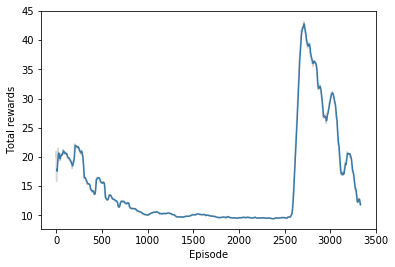

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

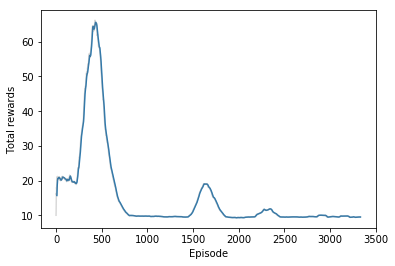

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

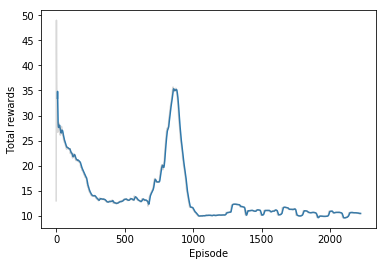

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

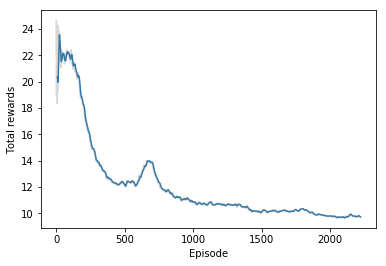

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

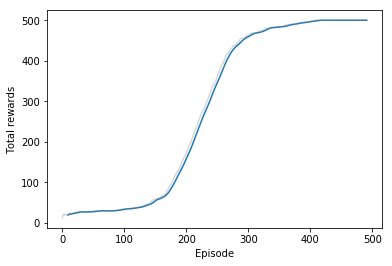

In [62]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

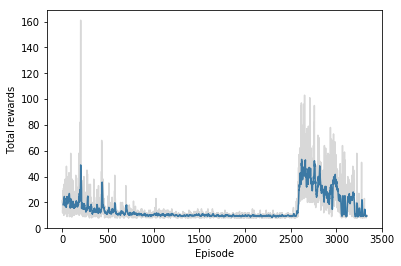

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

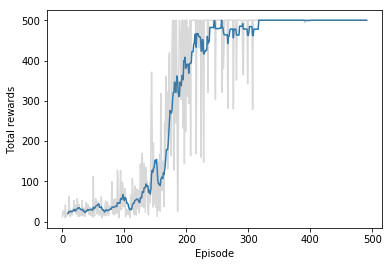

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.